In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
results304 = Table.read("./EIT/EIT304_LC_corrected_2008onwards_heliocentriccorr_linear.txt", format='ascii.commented_header',data_start=1,header_start=0)
results284 = Table.read("./EIT/EIT284_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results195 = Table.read("./EIT/EIT195_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results171 = Table.read("./EIT/EIT171_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)

results304all = Table.read("./EIT/EIT304_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results284all = Table.read("./EIT/EIT284_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results195all = Table.read("./EIT/EIT195_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results171all= Table.read("./EIT/EIT171_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)

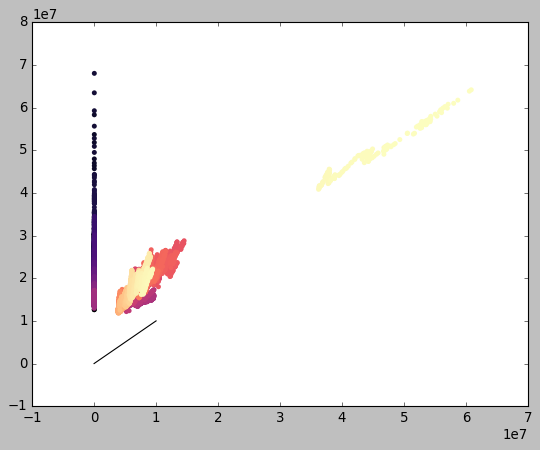

In [3]:
fig,ax= plt.subplots(1,1,figsize=(8,6))
ax.scatter(results171['flux_unc[DN/s]'],results171all['flux_unc[DN/s]'],c=results171['average_observation_time[JD]'],edgecolor='None',cmap='magma')
ax.plot(np.array((1.,1.e7)),np.array((1.,1.e7)),'k-')
plt.show()

In [4]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [5]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [6]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates_JD.txt", format="ascii.basic")
# Add another pseudo-bakeout to account for the discontinuity in early 2024.
pseudobakeout_on = np.round(astropy.time.Time({'year':2023, 'month':12, 'day':29, 'hour':18, 'minute':0}).jd,3)
pseudobakeout_off = np.round(astropy.time.Time({'year':2023, 'month':12, 'day':30, 'hour':0, 'minute':0}).jd,3)

bakeoutDates.add_row(['heaterOn', '29-dec-2023', '18:00', pseudobakeout_on])
bakeoutDates.add_row(['heaterOff', '30-dec-2023', '00:00', pseudobakeout_off])


heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
#print(heaterOn)
#print(heaterOff)

heaterOn = heaterOn[np.argsort(heaterOn['jd'])]
heaterOff = heaterOff[np.argsort(heaterOff['jd'])]

nBakeouts = 85

print(heaterOn[:nBakeouts])
print(heaterOff[:nBakeouts])


 status    date_beg  time_beg      jd    
-------- ----------- -------- -----------
heaterOn 23-may-1996    19:21 2450227.306
heaterOn 23-jun-1996    19:10 2450258.299
heaterOn 23-jul-1996    15:48 2450288.158
heaterOn 05-aug-1996    18:50 2450301.285
heaterOn 09-aug-1996    15:05 2450305.128
heaterOn 06-sep-1996    19:49 2450333.326
heaterOn 19-dec-1996    13:14 2450437.051
heaterOn 03-jan-1997    21:50  2450452.41
heaterOn 20-feb-1997    21:57 2450500.415
heaterOn 21-mar-1997    14:26 2450529.101
     ...         ...      ...         ...
heaterOn 02-dec-2015    18:08 2457359.256
heaterOn 26-may-2016    16:10 2457535.174
heaterOn 13-may-2017    03:23 2457886.641
heaterOn 04-may-2018    04:53 2458242.703
heaterOn 23-apr-2019    16:48   2458597.2
heaterOn 15-apr-2020    16:40 2458955.194
heaterOn 05-apr-2021    22:32 2459310.439
heaterOn 31-mar-2022    18:33 2459670.273
heaterOn 13-mar-2023    00:40 2460016.528
heaterOn 29-dec-2023    18:00  2460308.25
Length = 85 rows
  status    date_

In [7]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results304 = Table.read("./EIT/EIT304_LC_corrected_2008onwards_heliocentriccorr_linear.txt", format='ascii.commented_header',data_start=1,header_start=0)
results284 = Table.read("./EIT/EIT284_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results195 = Table.read("./EIT/EIT195_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results171 = Table.read("./EIT/EIT171_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
'''
results304 = Table.read("./EIT/EIT304_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results284 = Table.read("./EIT/EIT284_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results195 = Table.read("./EIT/EIT195_LC_corrected_all_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results171 = Table.read("./EIT/EIT171_LC_corrected_all_heliocentriccorr_uniform.txt", format='ascii.commented_header',data_start=1,header_start=0)
'''
results = [results304, results284, results195, results171]

(2463, 3)


In [6]:
print(results[0].colnames)

['average_observation_time[JD]', 'flux[DN/s]', 'flux_unc[DN/s]', 'last_data_point_before_bakeout', 'first_data_point_after_bakeout']


In [65]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, axes = plt.subplots(4,1,figsize=(16,12))

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    axes[3].text(jan1_thisyear + 180., -0.25, str(y),horizontalalignment='center',fontsize=10,backgroundcolor='None')

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)
    for m in range(2,4):
        m1 = str(2025) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    for i in range(nBakeouts):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

    
for i, ax in enumerate(axes):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs[~np.isnan(fs)])

    plotcolor = cs[i]
    axes[i].errorbar(ts, fs/fluxnorm, yerr=us/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor=plotcolor,markeredgecolor='None')
    #axes[i].plot(ts, 0.3*np.ones_like(ts), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(ws[i]), fontsize=16)
    axes[i].set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])

for ax in axes:
    ax.set_xticks([])

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,4.0)
    ax.set_xlim(2450000, 2460710)
    
    
    
#axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
'''
axes[0].set_ylim(0.,2.75)
axes[1].set_ylim(0.,4.)
axes[2].set_ylim(0.,3.0)
axes[3].set_ylim(0.,2.0)
'''
axes[3].set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.subplots_adjust(hspace=0.025)
#plt.show()
plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")
plt.savefig("./EIT_LCs_fullmission_lowres.png", bbox_inches="tight")

In [66]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, ax = plt.subplots(1,1,figsize=(16,6))

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    ax.text(jan1_thisyear + 180., -0.175e8, str(y),horizontalalignment='center',fontsize=11,backgroundcolor='None')

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
ax.axvline(jan1, color='k', ls='-', lw=1)

for m in range(2,4):
    m1 = str(2025) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
    m1 = astropy.time.Time(m1).jd
    ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)

for i in range(nBakeouts):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    plotcolor = cs[i]
    #ax.errorbar(ts, fs, yerr=us, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor, markeredgecolor='None',ecolor=plotcolor)
    ax.plot(ts, fs, ls='None',marker='.',ms=2,color=plotcolor, markeredgecolor='None',alpha=1,zorder=i+1)
    ax.fill_between(ts, fs-us, fs+us , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    ax.errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=r"${0}\AA$".format(ws[i]),markeredgecolor='None',ecolor=plotcolor)

ax.set_ylabel(r"Flux [DN/s]", fontsize=16)
#ax.set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])

ax.set_xticks([])
ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.1e8,1.8e8)
ax.set_xlim(2450000, 2460710)
   
ax.set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.legend(loc=(0.85,0.7),edgecolor='None')
#plt.show()
plt.savefig("./EIT_LCs_fullmission_allsameplot_unnormalized.pdf", bbox_inches="tight")
plt.savefig("./EIT_LCs_fullmission_allsameplot_unnormalized_lowres.png", bbox_inches="tight")

In [73]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, ax = plt.subplots(1,1,figsize=(16,6))

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    ax.text(jan1_thisyear + 180., -0.25, str(y),horizontalalignment='center',fontsize=11,backgroundcolor='None')

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
ax.axvline(jan1, color='k', ls='-', lw=1)

for m in range(2,4):
    m1 = str(2025) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
    m1 = astropy.time.Time(m1).jd
    ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
for i in range(nBakeouts):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    
for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    plotcolor = cs[i]
    #ax.errorbar(ts, fs/fluxnorm, yerr=us/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor=plotcolor,markeredgecolor='None')
    ax.plot(ts, fs/fluxnorm, ls='None',marker='.',ms=2,color=plotcolor, markeredgecolor='None',alpha=1,zorder=i+1)
    ax.fill_between(ts, (fs-us)/fluxnorm, (fs+us)/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    ax.errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=r"${0}\AA$".format(ws[i]),markeredgecolor='None',ecolor=plotcolor)

ax.set_ylabel(r"Flux [normalized]", fontsize=16)
#ax.set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])


ax.set_xticks([])
ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.1,4.)
#ax.set_xlim(2450000, 2460020)
ax.set_xlim(2450000, 2460710)
   
ax.set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.legend(loc='upper right',edgecolor='None')
#plt.show()
plt.savefig("./EIT_LCs_fullmission_allsameplot_normalized.pdf", bbox_inches="tight")
plt.savefig("./EIT_LCs_fullmission_allsameplot_normalized_lowres.png", bbox_inches="tight")

In [115]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, axes = plt.subplots(2,1,figsize=(16,10))

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        for ax in axes:
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    axes[1].text(jan1_thisyear + 180., -0.315, "'"+str(y)[-2:],horizontalalignment='center',fontsize=16,backgroundcolor='None')

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)

for m in range(2,4):
    m1 = str(2025) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
    m1 = astropy.time.Time(m1).jd
    for ax in axes:
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)

for i in range(nBakeouts):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    for ax in axes:
        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    plotcolor = cs[i]
    #axes[0].errorbar(ts, fs, yerr=us, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor, markeredgecolor='None',ecolor=plotcolor)
    axes[0].plot(ts, fs, ls='None',marker='.',ms=2,color=plotcolor, markeredgecolor='None',alpha=1,zorder=i+1)

    t1998 = 2451050
    t284 = 2450500
    
    if i != 1:
        axes[0].fill_between(ts[ts < t1998], (fs-us)[ts < t1998], (fs+us)[ts < t1998] , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[0].fill_between(ts[ts >= t1998], (fs-us)[ts >= t1998], (fs+us)[ts >= t1998] , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    else:
        axes[0].fill_between(ts[ts < t284], (fs-us)[ts < t284], (fs+us)[ts < t284] , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[0].fill_between(ts[(ts >= t284) & (ts < t1998)], (fs-us)[(ts >= t284) & (ts < t1998)], (fs+us)[(ts >= t284) & (ts < t1998)] , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[0].fill_between(ts[ts >= t1998], (fs-us)[ts >= t1998], (fs+us)[ts >= t1998] , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    axes[1].errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=r"${0}\AA$".format(ws[i]),markeredgecolor='None',ecolor=plotcolor)

    fluxnorm = np.median(fs[~np.isnan(fs)])

    #axes[1].errorbar(ts, fs/fluxnorm, yerr=us/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor=plotcolor,markeredgecolor='None')
    axes[1].plot(ts, fs/fluxnorm, ls='None',marker='.',ms=2,color=plotcolor, markeredgecolor='None',alpha=1,zorder=i+1)
    if i != 1:
        axes[1].fill_between(ts[ts < t1998], (fs-us)[ts < t1998]/fluxnorm, (fs+us)[ts < t1998]/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[1].fill_between(ts[ts >= t1998], (fs-us)[ts >= t1998]/fluxnorm, (fs+us)[ts >= t1998]/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    else:
        axes[1].fill_between(ts[ts < t284], (fs-us)[ts < t284]/fluxnorm, (fs+us)[ts < t284]/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[1].fill_between(ts[(ts >= t284) & (ts < t1998)], (fs-us)[(ts >= t284) & (ts < t1998)]/fluxnorm, (fs+us)[(ts >= t284) & (ts < t1998)]/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
        axes[1].fill_between(ts[ts >= t1998], (fs-us)[ts >= t1998]/fluxnorm, (fs+us)[ts >= t1998]/fluxnorm , color=plotcolor,edgecolor='None', alpha=0.4,zorder=i)
    #axes[1].errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=r"${0}\AA$".format(ws[i]),markeredgecolor='None',ecolor=plotcolor)


axes[0].set_ylabel(r"Flux [count/s]", fontsize=20)
axes[1].set_ylabel(r"Flux [normalized]", fontsize=20)
#ax.set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
for ax in axes:
    ax.set_xticks([])
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.set_xlim(2450000, 2460020)
    ax.set_xlim(2450000, 2460710)

axes[0].set_ylim(-0.1e8,1.8e8)
axes[1].set_ylim(-0.1,3.75)
axes[1].set_xlabel('Observation time', fontsize=20,labelpad=20)
axes[1].legend(loc=(0.725,0.48),edgecolor='None',fontsize=20)

axes[0].yaxis.get_offset_text().set_fontsize(16)
plt.subplots_adjust(hspace=0.03)
#plt.show()

plt.savefig("./EIT_LCs_fullmission_unnorm&norm.pdf", bbox_inches="tight")
plt.savefig("./EIT_LCs_fullmission_unnorm&norm_lowres.png", bbox_inches="tight")

In [117]:
for i in range(4):
    print(ws[i])
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']
    fluxnorm = np.median(fs[~np.isnan(fs)])

    frac_var = np.ptp(fs)/fluxnorm
    print(frac_var)


304
1.7932806167973108
284
3.2749639990500032
195
2.361257066836361
171
1.1869436121905383


In [78]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, ax = plt.subplots(1,1,figsize=(16,9))

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    freq, pow = LombScargle(ts,fs,us).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))

    plotcolor = cs[i]
    ax.plot(1/freq,pow*10**-(2*i),ls='-',color=plotcolor,alpha=0.9)

wfreq, wpow = LombScargle(ts,np.ones_like(fs)).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))
ax.plot(1/wfreq,wpow*10**5,ls='-',color='k',alpha=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.,3.5)

#ax.axvline(26.24,color='b',ls='-',zorder=1,lw=10,alpha=0.5)     #solar rotation
ax.fill_between(x=np.array((24.47,34.22)),y1=1.e-12*np.ones(2),y2=3.e5*np.ones(2),color='b',alpha=0.25)

ax.axvline(178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(178./2., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
ax.axvline(178./4., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
#ax.axvline(178./8., color='k',ls=':',zorder=1)     #1/8 period of L1 halo orbit, ~0.75 months
ax.axvline(365.,color='k',ls=':',zorder=1)      #1 year
#ax.axvline(11*365.,color='b',ls='-',zorder=1) #magnetic cycle
ax.fill_between(x=365.25*np.array((11.,12.6)),y1=1.e-12*np.ones(2),y2=3.e5*np.ones(2),color='b',alpha=0.25)
ax.axvline(178./6.,color='k',ls=':',zorder=1) #30 days
    
ax.text(26.24/0.76, 2e4, 'solar'+'\n'+'rotation',fontsize=18,color='b')
ax.text(178/0.97, 2.e4, r'$P_{L1}$',fontsize=18)
ax.text(365./0.97, 2.e4, r'$1\ \mathrm{yr}$',fontsize=18)
ax.text(178/1.95, 8.e3, r'$\frac{1}{2} P_{L1}$',fontsize=18,color='k')
ax.text(178/3.95,3.e3, r'$\frac{1}{4} P_{L1}$',fontsize=18,color='k')
#ax.text(178./8.05, 1.4e2, '1/8 of L1'+'\n'+'halo orbit',fontsize=18,color='k')
#ax.text(30., 3.75e3, '30 d',fontsize=12,color='k')
ax.text(178/5.93,0.9e3, r'$\frac{1}{6} P_{L1}$',fontsize=18,color='k')

ax.text((365*11)/0.83, 2e4, 'solar'+'\n'+'magnetic cycle',fontsize=18,color='b')


ax.text(6.e3, 5*10**(1), r'Window'+'\n'+'function'+'\n'+r'$[\mathrm{offset}\ \times 10^{5}]$',fontsize=16)
ax.text(6.e3, 1.7e-1, r'$304\AA$',fontsize=18)
ax.text(6.e3, 3.e-4, r'$284\AA$'+'\n'+r'$[\mathrm{offset}\ \times 10^{-2}]$',fontsize=18)
ax.text(6.e3, 3.e-6, r'$195\AA$'+'\n'+r'$[\mathrm{offset}\ \times 10^{-4}]$',fontsize=18)
ax.text(6.e3, 3.e-8, r'$171\AA$'+'\n'+r'$[\mathrm{offset}\ \times 10^{-6}]$',fontsize=18)

ax.set_ylim(1.e-12,3.*10**(5))
ax.set_xlim(2,2.2e4)
ax.set_xlabel("period [d]", fontsize=25)
ax.set_ylabel("power [unitless]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

#ax.set_title(r'LS periodograms of EIT full sun, full mission LCs',fontsize=20)
#plt.show()
plt.savefig("./EIT_periodograms_fullmission.pdf", bbox_inches="tight")

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_13531/3543101341.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.,3.5)


<>:39: SyntaxWarning: invalid escape sequence '\A'
<>:39: SyntaxWarning: invalid escape sequence '\A'
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_7789/4020286965.py:39: SyntaxWarning: invalid escape sequence '\A'
  '''
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_7789/4020286965.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.,3.5)


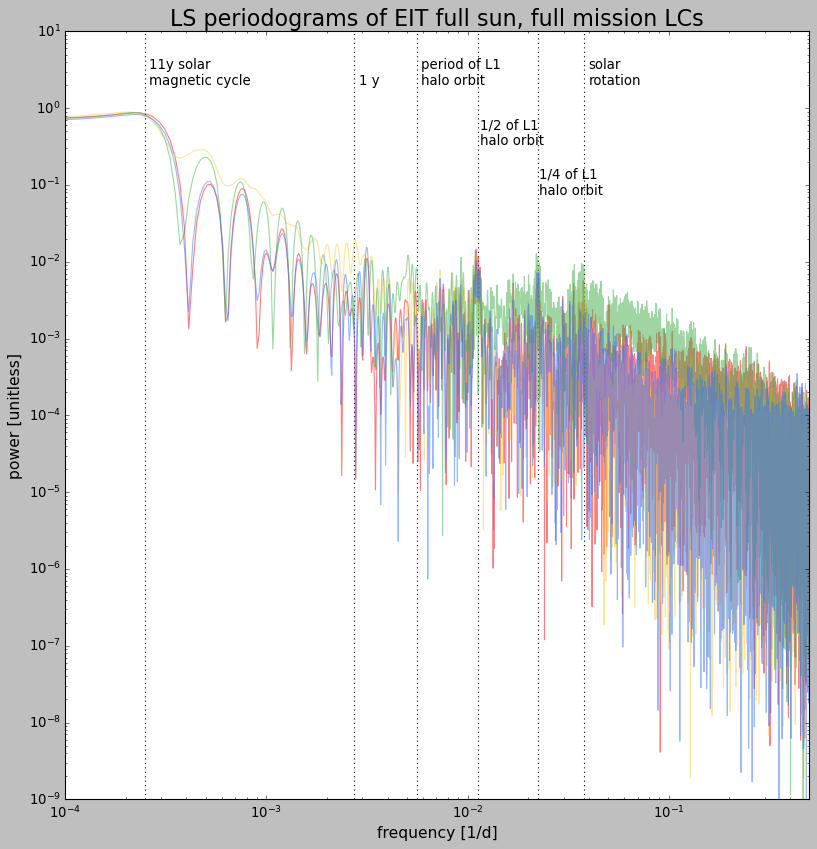

In [14]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, ax = plt.subplots(1,1,figsize=(12,12))
wfreq, wpow = LombScargle(ts,np.ones_like(fs)).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))
#ax.plot(wfreq,wpow,ls='-',color='k',alpha=1)

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    freq, pow = LombScargle(ts,fs,us).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))

    plotcolor = cs[i]
    ax.plot(freq,pow,ls='-',color=plotcolor,alpha=0.5)


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.,3.5)

ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle
    
ax.text(1.05/26.24, 2.e0, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 2.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 2.e0, '1 y',fontsize=12)
ax.text(2.05/178., 3.3e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(4.05/178., 0.75e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(1.05/(365*11), 2.e0, '11y solar'+'\n'+'magnetic cycle',fontsize=12)

'''
ax.text(1.1e-4, 5*10**(1), r'Window'+'\n'+'function'+'\n'+r'[offset * $10^{5}$]',fontsize=14)
ax.text(1.1e-4, 5.e-1, r'$304\AA$',fontsize=16)
ax.text(1.1e-4, 5.e-4, r'$284\AA$'+'\n'+r'[offset * $10^{-2}$]',fontsize=16)
ax.text(1.1e-4, 5.e-6, r'$195\AA$'+'\n'+r'[offset * $10^{-4}$]',fontsize=16)
ax.text(1.1e-4, 5.e-8, r'$171\AA$'+'\n'+r'[offset * $10^{-6}$]',fontsize=16)
'''
ax.set_ylim(1.e-9,10**(1))
ax.set_xlim(1.e-4,0.5)
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_title(r'LS periodograms of EIT full sun, full mission LCs',fontsize=20)
#plt.show()
plt.savefig("./EIT_periodograms_fullmission_samesubplot.pdf", bbox_inches="tight")

In [8]:
# corner plot showing other solar missions
# normalized by heliocentric distance
SEMcorr = Table.read("./CELIAS-SEM/SEMDailyData_norm_1storderDegradationCorrected.txt",format="ascii")
SEMcorr = SEMcorr[SEMcorr['t_obs[JD]'] >= 2450190.]
print(SEMcorr.colnames)
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)


# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]']
['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']
['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_171_unc[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_195_unc[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_284_unc[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_304_unc[arb.units]', 'transmitted_flux_sumEITBands[arb.units]', 'transmitted_flux_sumEITBands_unc[arb.units]', 'transmitted_flux_SEM1[arb.units]', 'transmitted_flux_SEM1_unc[arb.units]']
2452696.0
2458904.0
t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382         

In [9]:
def medianBinNormalize(tDaily, tEIT, fEIT, uEIT):
    '''
    median-bin the flux from one EIT band into daily values
    '''
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    med = np.median(binned_f[~np.isnan(binned_f)])
    return binned_f/med, binned_u/med


In [10]:
tDaily = np.arange(np.min(SEM['t_obs[JD]']), np.max(SEM['t_obs[JD]']),1)
print(tDaily)

bf_virgo, bu_virgo = medianBinNormalize(tDaily, VIRGO['t_obs[JD]'],VIRGO['flux[W/m^2]'], VIRGO['flux_unc[W/m^2]'])
bf_SEM1, bu_SEM1 = medianBinNormalize(tDaily, SEMcorr['t_obs[JD]'], SEMcorr['firstOrderFlux[counts/s]'], SEMcorr['firstOrderFluxUnc[counts/s]'])
bf_SEM0, bu_SEM0 = medianBinNormalize(tDaily, SEM['t_obs[JD]'], SEM['centralOrderFlux[counts/s]'], SEM['centralOrderFluxUnc[counts/s]'])
bf_SORCE, bu_SORCE = medianBinNormalize(tDaily, SORCE['date[JD]'], SORCE['transmitted_flux_sumEITBands[arb.units]'], SORCE['transmitted_flux_sumEITBands_unc[arb.units]'])

bf_304, bu_304 = medianBinNormalize(tDaily, results[0]['average_observation_time[JD]'], results[0]['flux[DN/s]'], results[0]['flux_unc[DN/s]'])
bf_284, bu_284 = medianBinNormalize(tDaily, results[1]['average_observation_time[JD]'], results[1]['flux[DN/s]'], results[1]['flux_unc[DN/s]'])
bf_195, bu_195 = medianBinNormalize(tDaily, results[2]['average_observation_time[JD]'], results[2]['flux[DN/s]'], results[2]['flux_unc[DN/s]'])
bf_171, bu_171 = medianBinNormalize(tDaily, results[3]['average_observation_time[JD]'], results[3]['flux[DN/s]'], results[3]['flux_unc[DN/s]'])
tDaily = 0.5*(tDaily[1:] + tDaily[0:-1])

[2450190. 2450191. 2450192. ... 2460346. 2460347. 2460348.]


In [93]:
fig, axes = plt.subplots(4,4,figsize=(24,24))

bf_EIT = bf_284

divider00 = make_axes_locatable(axes[0,1])
cax00 = divider00.append_axes('left',size='5%', pad=0)
c_s = axes[0,0].scatter(bf_virgo, bf_SEM1,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
cbar = fig.colorbar(c_s, cax=cax00, orientation='vertical',)
cbar.ax.set_yticks(np.arange(2451000,2460000,1000))
cbar.set_label(label='obs. time [JD]',fontsize=25)
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.get_offset_text().set_fontsize(20)


axes[1,0].scatter(bf_virgo, bf_SEM0,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[2,0].scatter(bf_virgo, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,0].scatter(bf_virgo, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,1].axis('off')
axes[1,1].scatter(bf_SEM1, bf_SEM0,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[2,1].scatter(bf_SEM1, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,1].scatter(bf_SEM1, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,2].axis('off')
axes[1,2].axis('off')
axes[2,2].scatter(bf_SEM0, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,2].scatter(bf_SEM0, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,3].axis('off')
axes[1,3].axis('off')
axes[2,3].axis('off')
axes[3,3].scatter(bf_SORCE, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily))

for ax in axes[:,0]:
    ax.set_xlim(1.-0.002, 1.+0.002)

for ax in axes[:,1]:
    ax.set_xlim(0.5,2.1)

for ax in axes[:,2]:
    ax.set_xlim(0.,6)

for ax in axes[:,3]:
    ax.set_xlim(0.8,1.75)

for ax in axes[0]:
    ax.set_ylim(0.5,2.1)

for ax in axes[1]:
    ax.set_ylim(0.,6)

for ax in axes[2]:
    ax.set_ylim(0.8,1.75)

for ax in axes[3]:
    #ax.set_ylim(0.5,2.5)
    ax.set_ylim(0.,4)

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[2,0].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
axes[2,2].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[3,1].set_yticks([])
axes[2,2].set_yticks([])
axes[3,2].set_yticks([])
axes[3,3].set_yticks([])

axes[0,0].set_ylabel(r"norm. SEM $1^{st}$ order flux",fontsize=25)
axes[1,0].set_ylabel(r"norm. SEM $0^{th}$ order flux",fontsize=25)
axes[2,0].set_ylabel(r"norm. SORCE UV flux",fontsize=25)
axes[3,0].set_ylabel(r"norm. EIT $284\AA$ flux",fontsize=25)

axes[3,0].set_xlabel(r"norm. VIRGO TSI flux",fontsize=25)
axes[3,1].set_xlabel(r"norm. SEM $1^{st}$ order flux",fontsize=25)
axes[3,2].set_xlabel(r"norm. SEM $0^{th}$ order flux",fontsize=25)
axes[3,3].set_xlabel(r"norm. SORCE UV flux",fontsize=25)
x = np.arange(10)
for ax in [axes[0,0],axes[1,0],axes[2,0],axes[3,0],axes[1,1],axes[2,1],axes[3,1],axes[2,2],axes[3,2],axes[3,3]]:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.plot(x,x,'k-',zorder=1)

axes[3,0].set_yticks(np.arange(0.,4.,0.5))
axes[3,0].set_xticks(np.arange(1.-0.002,1.0015,0.001))

axes[3,2].set_xticks(np.arange(0.,5.5,1))

plt.subplots_adjust(hspace=0.01,wspace=0.01)
#plt.show()
plt.savefig("allInstrumentComparison.pdf",bbox_inches='tight')
plt.savefig("allInstrumentComparison_lowres.png",bbox_inches='tight')

In [11]:
def normalizedFluxRatio(f1, f2, u1, u2):
    """
    assume f1, f2 are defined on the same array of times and therefore have the same length
    """

    med_f1 = np.median(f1[~np.isnan(f1)])
    med_f2 = np.median(f2[~np.isnan(f2)])

    ratio = (f1/med_f1)/(f2/med_f2)

    unc_med_f1 = np.sqrt((np.pi/2) * np.sum(u1[~np.isnan(u1)]**2/len(u1[~np.isnan(u1)])))
    unc_med_f2 = np.sqrt((np.pi/2) * np.sum(u2[~np.isnan(u2)]**2/len(u2[~np.isnan(u2)])))

    unc_ratio_sq = ((med_f2/(f2 * med_f1))**2 * u1**2) + (((f1*med_f2)/med_f1)**2 * (1/f2**2)**2 * u2**2) + (((f1*med_f2)/f2)**2 * (1/med_f1**2)**2 * unc_med_f1**2) + ((f1/(f2 * med_f1))**2 * unc_med_f2**2)
    unc_ratio = np.sqrt(unc_ratio_sq)

    return ratio, unc_ratio

In [94]:
tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
uSORCE = np.array(SORCE['transmitted_flux_sumEITBands_unc[arb.units]'])

fig, axes = plt.subplots(2,1,figsize=(16,8))
#ax.axvline(1.e8,color='b',linestyle='-',lw=0.25,zorder=2,label='bakeout')
labels = [r'EIT $304\AA$', r'EIT $284\AA$', r'EIT $195\AA$', r'EIT $171\AA$']

fSum_to_plot = np.zeros_like(tSORCE)
usqSum_to_plot = np.zeros_like(tSORCE)
ind_to_plot = np.zeros_like(tSORCE)


for i in range(4):
    result = results[i]
    tEIT = result['average_observation_time[JD]']
    fEIT = result['flux[DN/s]']
    uEIT = result['flux_unc[DN/s]']

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    
    fSum_to_plot[tSORCE_ind] = fSum_to_plot[tSORCE_ind] + fEIT[tEIT_ind]
    usqSum_to_plot[tSORCE_ind] = usqSum_to_plot[tSORCE_ind] + (uEIT[tEIT_ind])**2
    ind_to_plot[tSORCE_ind] = ind_to_plot[tSORCE_ind] + 1

#ax.errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])), (uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)])), marker='.',ls='None',color=cs[i],capsize=0,elinewidth=1,ms=5,alpha=0.5,label=labels[i],zorder=i)
tSORCEplot = tSORCE[ind_to_plot == 4]
fSORCEplot = fSORCE[ind_to_plot == 4]
uSORCEplot = uSORCE[ind_to_plot == 4]
fSum_to_plot = fSum_to_plot[ind_to_plot == 4]
usqSum_to_plot = usqSum_to_plot[ind_to_plot == 4]

sorce_ratio, sorce_unc_ratio = normalizedFluxRatio(f1=fSum_to_plot, f2=fSORCEplot, u1=np.sqrt(usqSum_to_plot), u2=uSORCEplot)
'''
print(np.shape(tSORCE))
print(np.shape(tSORCEplot))
print(np.shape(fSum_to_plot))
print(np.shape(usqSum_to_plot))

ax.plot(tSORCEplot, (fSum_to_plot/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)]))/(fSORCEplot/np.median(fSORCEplot[~np.isnan(fSORCEplot)])), marker='.',ls='None',color=cs[i],ms=2,alpha=1,zorder=2)

# prevent awkward fill between across the 2013-2014 gap
firsthalf = tSORCEplot < 2456658
ax.fill_between(tSORCEplot[firsthalf], 
                (fSum_to_plot[firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)]))/(fSORCEplot[firsthalf]/np.median(fSORCEplot[~np.isnan(fSORCEplot)])) - ((usqSum_to_plot**0.5)[firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)])), 
                (fSum_to_plot[firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)]))/(fSORCEplot[firsthalf]/np.median(fSORCEplot[~np.isnan(fSORCEplot)])) + ((usqSum_to_plot**0.5)[firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)])),edgecolor='None',color=cs[i],alpha=0.4,zorder=1)
ax.fill_between(tSORCEplot[~firsthalf], 
                (fSum_to_plot[~firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)]))/(fSORCEplot[~firsthalf]/np.median(fSORCEplot[~np.isnan(fSORCEplot)])) - ((usqSum_to_plot**0.5)[~firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)])), 
                (fSum_to_plot[~firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)]))/(fSORCEplot[~firsthalf]/np.median(fSORCEplot[~np.isnan(fSORCEplot)])) + ((usqSum_to_plot**0.5)[~firsthalf]/np.median(fSum_to_plot[~np.isnan(fSum_to_plot)])),edgecolor='None',color=cs[i],alpha=0.4,zorder=1)

'''
thalf = 2456600
tsecondhalf = 2456658
sorcenorm = np.median(fSORCE)
axes[0].plot(tSORCE, fSORCE/sorcenorm, marker='.',ls='None',color='k',ms=2,alpha=1,zorder=3)
axes[0].fill_between(tSORCE[tSORCE < thalf], ((fSORCE - uSORCE)[tSORCE < thalf])/sorcenorm, ((fSORCE+uSORCE)[tSORCE < thalf])/sorcenorm, edgecolor='None',color=cs[-1],alpha=0.4,zorder=1)
axes[0].fill_between(tSORCE[tSORCE >= tsecondhalf], ((fSORCE - uSORCE)[tSORCE >= tsecondhalf])/sorcenorm, ((fSORCE+uSORCE)[tSORCE >= tsecondhalf])/sorcenorm, edgecolor='None',color=cs[-1],alpha=0.4,zorder=1)
axes[0].set_ylabel(r"$\mathrm{norm.\ SORCE\ UV\ flux}$",fontsize=22)


firsthalf = tSORCEplot < 2456658
axes[1].plot(tSORCEplot, sorce_ratio, marker='.',ls='None',color='k',ms=2,alpha=1,zorder=3)
axes[1].fill_between(tSORCEplot[firsthalf], sorce_ratio[firsthalf] - sorce_unc_ratio[firsthalf],sorce_ratio[firsthalf] + sorce_unc_ratio[firsthalf], edgecolor='None',color=cs[-1],alpha=0.4,zorder=1)
axes[1].fill_between(tSORCEplot[~firsthalf], sorce_ratio[~firsthalf] - sorce_unc_ratio[~firsthalf],sorce_ratio[~firsthalf] + sorce_unc_ratio[~firsthalf], edgecolor='None',color=cs[-1],alpha=0.4,zorder=1)
axes[1].fill_between(tSORCEplot[firsthalf], sorce_ratio[firsthalf] - np.sqrt(usqSum_to_plot)[firsthalf]/np.median(fSum_to_plot),sorce_ratio[firsthalf] + np.sqrt(usqSum_to_plot)[firsthalf]/np.median(fSum_to_plot), edgecolor='None',color='k',alpha=0.4,zorder=2)
axes[1].fill_between(tSORCEplot[~firsthalf], sorce_ratio[~firsthalf] - np.sqrt(usqSum_to_plot)[~firsthalf]/np.median(fSum_to_plot),sorce_ratio[~firsthalf] + np.sqrt(usqSum_to_plot)[~firsthalf]/np.median(fSum_to_plot), edgecolor='None',color='k',alpha=0.4,zorder=2)

axes[1].set_ylim(0.,2.1)

axes[1].set_ylabel(r"$\frac{\mathrm{norm.\ summed\ EIT}\ \mathrm{flux}}{\mathrm{norm.\ SORCE\ UV\ flux}}$",fontsize=30)

    
for ax in axes:
    ax.set_xlim(2452600,2458950)
    ax.axhline(1.0,color='k',ls=':')
    for i in range(nBakeouts):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']
    
        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
        
    ax.axvline(2454783.150532, color='r', lw=3)#,label='12 Nov 2008') #Nov 12, 2008
    #ax.legend(loc='upper right')

    ax.set_xticks([])

    for i, y in enumerate(np.arange(2003,2020)):
        jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
        jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
        
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1) 
        if ax == axes[1]:
            ax.text(jan1_thisyear + 180., -0.15, str(y),horizontalalignment='center',fontsize=18,backgroundcolor='None')
    jan1_2020 = '2020-01-01T00:00:00.000Z'
    jan1_2020 = astropy.time.Time(jan1_2020).jd
    ax.axvline(jan1_2020,color='k',ls='-',lw=1,zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.subplots_adjust(hspace=0.05,top=1.1)
#plt.show()
plt.savefig("./ratio_sumEITbands_to_SORCE_2008onwards_bakeoutlineup_samesubplot.pdf",bbox_inches="tight")
plt.savefig("./ratio_sumEITbands_to_SORCE_2008onwards_bakeoutlineup_samesubplot_lowres.png",bbox_inches="tight")

In [95]:
VIRGOh = Table.read("./VIRGO/virgoHourlyData.txt",format="ascii")
VIRGOh = VIRGOh[VIRGOh['t_obs[JD]'] >= 2450190.]
print(VIRGOh)

 t_obs[JD]  flux[W/m^2] flux_unc[W/m^2]
----------- ----------- ---------------
 2450190.02    1360.417           0.137
2450190.062    1360.415           0.137
2450190.104    1360.413           0.136
2450190.145    1360.411           0.136
2450190.187    1360.411           0.136
2450190.229    1360.407           0.136
 2450190.27    1360.405           0.135
2450190.312    1360.402           0.135
2450190.354    1360.401           0.135
2450190.395    1360.398           0.134
        ...         ...             ...
2460263.062    1361.758           0.173
2460263.104    1361.756           0.174
2460263.145    1361.755           0.175
2460263.187    1361.755           0.176
2460263.229    1361.753           0.177
 2460263.27    1361.751           0.178
2460263.312    1361.751           0.179
2460263.354    1361.749           0.181
2460263.395    1361.749           0.181
2460263.437    1361.749           0.181
Length = 241763 rows


In [12]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]


1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


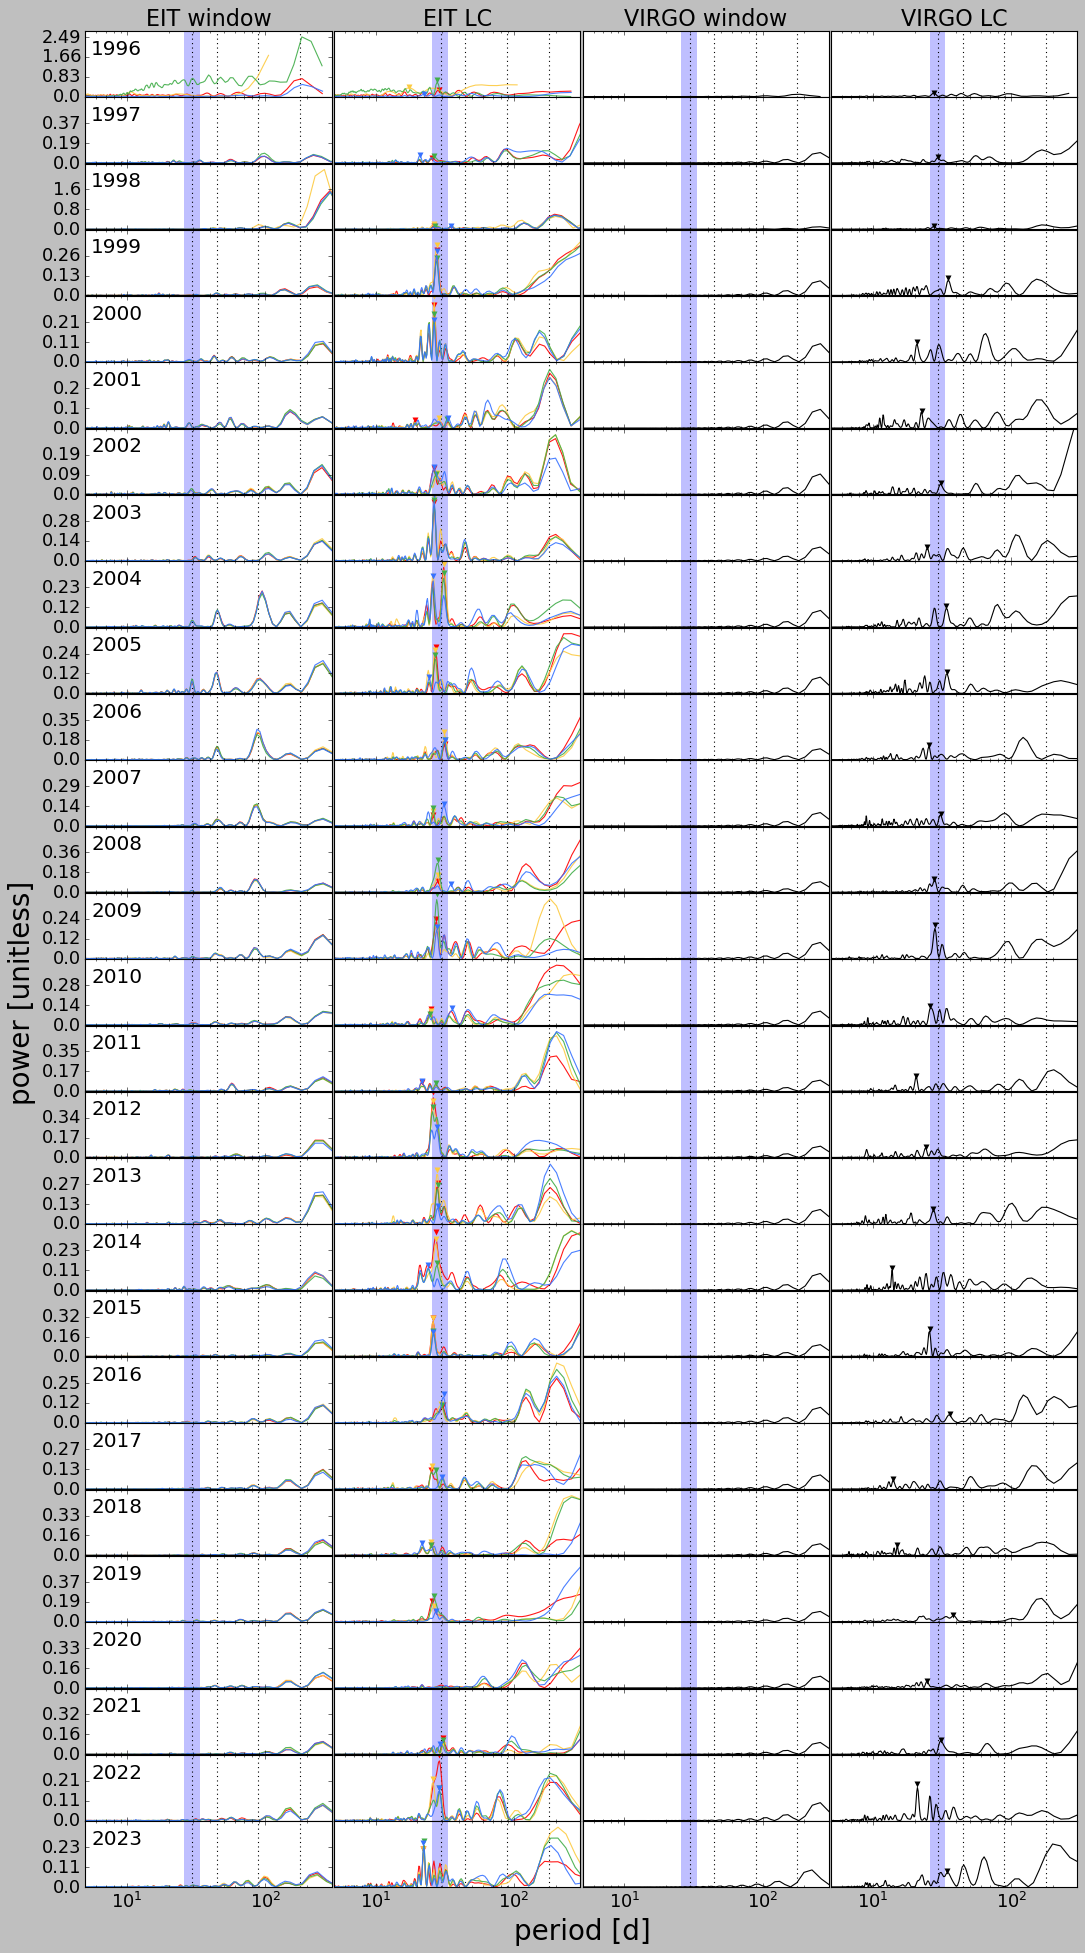

In [98]:
# Make a version of Annelies' plot. 
# each row is 1 year
# v1: 4 columns. EIT window, EIT data, VIRGO window, VIRGO data
# v2: 2 columns. EIT data, VIRGO data

ys = np.arange(1996,2024)
det_304 = np.zeros_like(ys).astype(float)
det_284 = np.zeros_like(ys).astype(float)
det_195 = np.zeros_like(ys).astype(float)
det_171 = np.zeros_like(ys).astype(float)
det_virgo = np.zeros_like(ys).astype(float)

fig, axes = plt.subplots(28,4,figsize=(16,29))

for j, y in enumerate(np.arange(1996,2024)):
    print(y)
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

    jan1_nextyear = '{0}-01-01T00:00:00.000Z'.format(str(y+1))
    jan1_nextyear = astropy.time.Time(jan1_nextyear).jd

    maxpow=0
    for i in range(4):
        plotcolor = cs[i]
        result = results[i]
        ts = result['average_observation_time[JD]']
        fs = result['flux[DN/s]']
        us = result['flux_unc[DN/s]']

        thisyearmask = (ts >= jan1_thisyear) & (ts < jan1_nextyear)
    
        fluxnorm = np.median(fs)
        
        try:
            ls = LombScargle(ts[thisyearmask],fs[thisyearmask],us[thisyearmask])
            freq, pow = ls.autopower(minimum_frequency=(1./np.ptp(ts[thisyearmask])), maximum_frequency=(1./2.))
            per = 1/freq
            #freq, pow = ls.autopower(minimum_frequency=(1./45.), maximum_frequency=(1./2.))

            mp = np.max(pow[per < 40])
            argmaxpow = np.argmax(pow[per < 40])
            freqmaxpow = freq[per < 40][argmaxpow]

            FAP = ls.false_alarm_probability(mp)

            if FAP < 0.001:
                axes[j,1].plot(1./freqmaxpow,mp*1.1,color=plotcolor,marker='v',ls='None',mec='None')
                if i==0:
                    det_304[j] = 1./freqmaxpow
                elif i==1:
                    det_284[j] = 1./freqmaxpow
                elif i==2:
                    det_195[j] = 1./freqmaxpow
                elif i==3:
                    det_171[j] = 1./freqmaxpow
            
            if np.max(pow) > maxpow:
                maxpow = np.max(pow)
            
            plotcolor = cs[i]
            axes[j,1].plot(1/freq,pow,ls='-',color=plotcolor,alpha=0.9)

            wls = LombScargle(ts[thisyearmask],np.ones_like(fs[thisyearmask]))
            wfreq, wpow = wls.autopower(minimum_frequency=(1./np.ptp(ts[thisyearmask])), maximum_frequency=(1./2.))

            if np.max(wpow) > maxpow:
                maxpow = np.max(wpow)
            
            axes[j,0].plot(1/wfreq,wpow,ls='-',color=plotcolor,alpha=0.9)
        except ValueError:
            continue

    axes[j,0].text(5.5,0.65*maxpow*1.1,str(y),fontsize=18)

    virgo_thisyearmask = (VIRGOh['t_obs[JD]'] >= jan1_thisyear) & (VIRGOh['t_obs[JD]'] < jan1_nextyear)

    ls = LombScargle(VIRGOh['t_obs[JD]'][virgo_thisyearmask],VIRGOh['flux[W/m^2]'][virgo_thisyearmask],VIRGOh['flux_unc[W/m^2]'][virgo_thisyearmask])
    freq, pow = ls.autopower(minimum_frequency=(1./np.ptp(VIRGOh['t_obs[JD]'][virgo_thisyearmask])), maximum_frequency=(1./2.))

    per = 1/freq
    #freq, pow = ls.autopower(minimum_frequency=(1./45.), maximum_frequency=(1./2.))

    mp = np.max(pow[per < 40])
    argmaxpow = np.argmax(pow[per < 40])
    freqmaxpow = freq[per < 40][argmaxpow]
    
    FAP = ls.false_alarm_probability(mp)
    if FAP < 0.001:
        axes[j,3].plot(1./freqmaxpow,mp*1.1,color='k',marker='v',ls='None',mec='None')
        det_virgo[j] = 1./freqmaxpow
        
    axes[j,3].plot(1/freq,pow,ls='-',color='k',alpha=1)

    wls = LombScargle(VIRGOh['t_obs[JD]'][virgo_thisyearmask],np.ones_like(VIRGOh['flux[W/m^2]'][virgo_thisyearmask]))
    wfreq, wpow = wls.autopower(minimum_frequency=(1./np.ptp(VIRGOh['t_obs[JD]'][virgo_thisyearmask])), maximum_frequency=(1./2.))
    
    axes[j,2].plot(1/wfreq,wpow,ls='-',color='k',alpha=1)

    for k in range(4):
        axes[j,k].set_ylim(0,maxpow*1.1)
        axes[j,k].fill_between(x=np.array((25.67,33.40)),y1=-0.1*np.ones(2),y2=1.1*maxpow*np.ones(2),color='b',alpha=0.25,edgecolor='None')

    if y > 1996:
        axes[j,0].set_yticks(np.linspace(0,maxpow,4)[:-1])
        axes[j,0].set_yticklabels(np.round(np.linspace(0,maxpow,4)[:-1],2))
    else:
        axes[j,0].set_yticks(np.linspace(0,maxpow,4))
        axes[j,0].set_yticklabels(np.round(np.linspace(0,maxpow,4),2))


axes[0,0].set_title("EIT window",fontsize=20)
axes[0,1].set_title("EIT LC",fontsize=20)
axes[0,2].set_title("VIRGO window",fontsize=20)
axes[0,3].set_title("VIRGO LC",fontsize=20)

axes[14,0].set_ylabel('power [unitless]',fontsize=25)
for ax in np.ravel(axes[:-1,:]):
    ax.set_xticks([])
for ax in np.ravel(axes[:,1:]):
    ax.set_yticks([])
#for ax in axes[:,0]:
#    ax.set_yticks([0.,1.])
for ax in np.ravel(axes):
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlim(5,300)
    #ax.set_ylim(-0.1,1.1)
    #ax.axvline(27.,color='b')
    ax.axvline(178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(178./2., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(178./4., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(365.,color='k',ls=':',zorder=1)      #1 year
    ax.axvline(178./6.,color='k',ls=':',zorder=1) #30 days
    ax.tick_params(axis='both', which='major', labelsize=16)

    
axes[-1,2].set_xlabel('period [d]',fontsize=25,x=0)   
plt.subplots_adjust(hspace=0.01,wspace=0.01)
plt.show()
#plt.savefig("/Users/emily/Desktop/test.pdf")

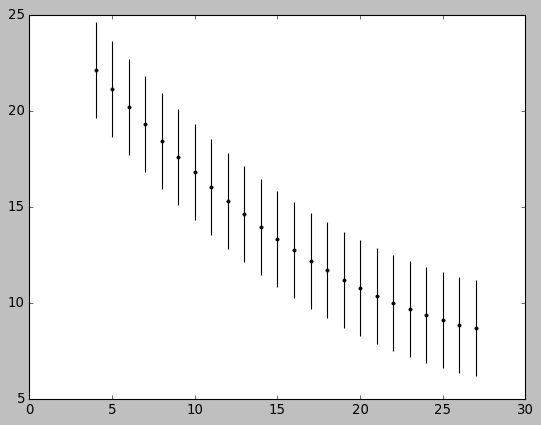

In [13]:
# from Jiang et al. 2011 https://arxiv.org/pdf/1102.1266
phase = np.arange(4,28)
lat = 26.4 - 34.2*(phase/30) + 16.1*(phase/30)**2
lat_unc = 2.5
lat_unc_lower = lat - lat_unc
lat_unc_upper = lat + lat_unc
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(phase,lat,yerr=lat_unc,color='k',marker='.',capsize=0,ls='None',elinewidth=1)
plt.show()

In [14]:
phase23 = np.linspace(1996,2009,30)
phase23 = phase23[4:28]

phase24 = np.linspace(2009,2020,30)
phase24 = phase24[4:28]

phase25 = np.linspace(2020,2031,30)
phase25 = phase25[4:28]

24.468157411812683 34.22053231939164
[25.10998037 25.05094397 24.99713759 24.94815995 24.90363644 24.86321796
 24.82657955 24.7934191  24.76345608 24.73643026 24.71210056 24.69024391
 24.67065424 24.65314149 24.63753077 24.62366158 24.61138707 24.60057346
 24.59109946 24.58285582 24.57574488 24.56968023 24.56458644 24.56039874]


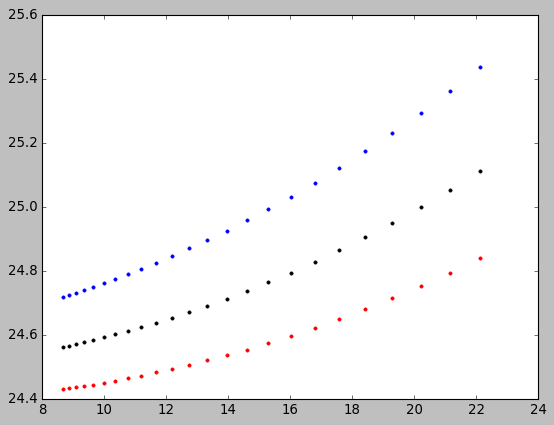

'\nang_vel = 451.5 - 65.3*np.cos((90-lat)*np.pi/180)**2 - 66.7*np.cos((90-lat)*np.pi/180)**4 # nHz\nang_vel_lower = 451.5 - 65.3*np.cos((90-lat-lat_unc)*np.pi/180)**2 - 66.7*np.cos((90-lat-lat_unc)*np.pi/180)**4 # nHz\nang_vel_upper = 451.5 - 65.3*np.cos((90-lat+lat_unc)*np.pi/180)**2 - 66.7*np.cos((90-lat+lat_unc)*np.pi/180)**4 # nHz\nang_vel = ang_vel *1.e-9 # Hz\nang_vel_lower = ang_vel_lower * 1.e-9\nang_vel_upper = ang_vel_upper * 1.e-9\nrot = (1./ang_vel) * (1./(3600*24))\nrot_upper = (1./ang_vel_lower) * (1./(3600*24))\nrot_lower = (1./ang_vel_upper) * (1./(3600*24))\nprint(rot)\nprint(rot_upper)\n'

In [15]:
# from wikipedia differential rotation
A = 14.713
B = -2.396
C = -1.797
A_unc = 0.0491
B_unc = 0.188
C_unc = 0.253
ang_vel = A + B*np.sin(lat*(np.pi/180.))**2 + C * np.sin(lat*(np.pi/180))**4
ang_vel_lower = (A+A_unc) + (B+B_unc)*np.sin((lat-lat_unc)*(np.pi/180.))**2 + (C+C_unc) * np.sin((lat-lat_unc)*(np.pi/180))**4
ang_vel_upper = (A-A_unc) + (B-B_unc)*np.sin((lat+lat_unc)*(np.pi/180.))**2 + (C-C_unc) * np.sin((lat+lat_unc)*(np.pi/180))**4

max_ang_vel = A
min_ang_vel = A + B + C
min_rot = (1/max_ang_vel) * 360
max_rot = (1/min_ang_vel) * 360
print(min_rot, max_rot)

rot = (1/ang_vel) * 360
rot_lower = (1/ang_vel_upper) * 360
rot_upper = (1/ang_vel_lower) * 360
print(rot)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(lat, rot,'k.')
ax.plot(lat, rot_lower,'b.')
ax.plot(lat, rot_upper,'r.')
plt.show()

'''
ang_vel = 451.5 - 65.3*np.cos((90-lat)*np.pi/180)**2 - 66.7*np.cos((90-lat)*np.pi/180)**4 # nHz
ang_vel_lower = 451.5 - 65.3*np.cos((90-lat-lat_unc)*np.pi/180)**2 - 66.7*np.cos((90-lat-lat_unc)*np.pi/180)**4 # nHz
ang_vel_upper = 451.5 - 65.3*np.cos((90-lat+lat_unc)*np.pi/180)**2 - 66.7*np.cos((90-lat+lat_unc)*np.pi/180)**4 # nHz
ang_vel = ang_vel *1.e-9 # Hz
ang_vel_lower = ang_vel_lower * 1.e-9
ang_vel_upper = ang_vel_upper * 1.e-9
rot = (1./ang_vel) * (1./(3600*24))
rot_upper = (1./ang_vel_lower) * (1./(3600*24))
rot_lower = (1./ang_vel_upper) * (1./(3600*24))
print(rot)
print(rot_upper)
'''

In [16]:
av = 460*1.e-9
print((1/av)*(1/(3600*24)))
av = 440*1.e-9
print((1/av)*(1/(3600*24)))

25.1610305958132
26.3047138047138


In [17]:
print(det_171)
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(ys[det_304>0], det_304[det_304>0], marker='.', color=cs[0],ls='None',ms=15,alpha=0.75)
ax.plot(ys[det_284>0], det_284[det_284>0], marker='.', color=cs[1],ls='None',ms=15,alpha=0.75)
ax.plot(ys[det_195>0], det_195[det_195>0], marker='.', color=cs[2],ls='None',ms=15,alpha=0.75)
ax.plot(ys[det_171>0], det_171[det_171>0], marker='.', color=cs[3],ls='None',ms=15,alpha=0.75)
ax.plot(ys[det_virgo>0], det_virgo[det_virgo>0], marker='.', color='k',ls='None',ms=15,alpha=0.75)

#ax.fill_between(x=np.arange(1995,2026), y1 = 25.67*np.ones_like(np.arange(1995,2026)),y2 = 33.40*np.ones_like(np.arange(1995,2026)),color='b',alpha=0.25,edgecolor='None')
ax.set_xlabel('year',fontsize=25)
ax.set_ylabel('detected period',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(phase23,rot,'k-',lw=2)
ax.plot(phase24,rot,'k-',lw=2)
ax.plot(phase25,rot,'k-',lw=2)

xlabels = []
for y in ys:
    xlabels.append("'"+str(y)[-2:])
ax.set_xticks(ys)
ax.set_xlim(1995.5,2023.5)
ax.set_xticklabels(xlabels)
ax.axvline(2009,color='k',ls=':')
ax.axvline(2020,color='k',ls=':')
plt.show()

NameError: name 'det_171' is not defined

# do a GP fit to find the MAP period instead of just picking the highest periodogram peak

In [18]:
import celerite
import emcee
from celerite import terms
from celerite.modeling import Model
import autograd.numpy as anp
from scipy.optimize import minimize
import corner

<frozen importlib._bootstrap>:488: FutureWarning: pybind11-bound class 'celerite.solver.CholeskySolver' is using an old-style placement-new '__setstate__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.


In [19]:
# this comes directly from celerite documentation
# see Foreman-Mackey+2017 eqs 55-56
class QPApproxTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = anp.exp(log_b)
        return (
            anp.exp(log_a) * (1.0 + b) / (2.0 + b), anp.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = anp.exp(log_b)
        return (
            anp.exp(log_a) / (2.0 + b), 0.0,
            anp.exp(log_c), 2*anp.pi*anp.exp(-log_P),
        )
    
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)


In [20]:
def log_probability(params, gp, flux):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(flux) + lp

In [21]:
def runGPfit(bounds,log_a_init,log_b_init,log_c_init,log_P_init,time_to_fit,flux_to_fit,fluxerr_to_fit,time_to_condition,verbose=False,condition=True,plot=False):
    
    kernel = QPApproxTerm(log_a=log_a_init, log_b=log_b_init, log_c=log_c_init, log_P=log_P_init, bounds=bounds)
    
    gp = celerite.GP(kernel, mean=np.mean(flux_to_fit))
    gp.compute(time_to_fit, fluxerr_to_fit)  # You always need to call compute once.
    
    if verbose is True:
        print("Initial log likelihood: {0}".format(gp.log_likelihood(flux_to_fit)))
        print("parameter_dict:\n{0}".format(gp.get_parameter_dict()))
        print("parameter_names:\n{0}".format(gp.get_parameter_names()))
        print("parameter_vector:\n{0}".format(gp.get_parameter_vector()))
        print("parameter_bounds:\n{0}".format(gp.get_parameter_bounds()))

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(flux_to_fit, gp))
    gp.set_parameter_vector(r.x)
    #print(r)
    
    lsq_param_dict = gp.get_parameter_dict()
    #print(lsq_param_dict)
    
    if condition is True:
        pred_mean, pred_var = gp.predict(flux_to_fit, time_to_condition, return_var=True)
        pred_std = np.sqrt(pred_var)

        if plot is True:
            color = "#ff7f0e"

            fig,ax = plt.subplots(1,1,figsize=(8,6))
            plt.errorbar(time_to_fit, flux_to_fit, yerr=fluxerr_to_fit, fmt=".k", capsize=0)
            plt.plot(time_to_condition, pred_mean, color=color)
            plt.fill_between(time_to_condition, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                             edgecolor="none")
            plt.xlabel("t")
            plt.ylabel("flux")
            plt.show()
        
        return gp, pred_mean, pred_std

    else:
        return gp

In [ ]:
# Make a version of Annelies' plot. 
# each row is 1 year
# v1: 4 columns. EIT window, EIT data, VIRGO window, VIRGO data
# v2: 2 columns. EIT data, VIRGO data
ys = np.arange(1996,2025)
det_304 = np.zeros((2025-1996,4))
det_284 = np.zeros((2025-1996,4))
det_195 = np.zeros((2025-1996,4))
det_171 = np.zeros((2025-1996,4))
det_virgo = np.zeros((2025-1996,4))

for j, y in enumerate(np.arange(1996,2025)):
    print(y)
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

    jan1_nextyear = '{0}-01-01T00:00:00.000Z'.format(str(y+1))
    jan1_nextyear = astropy.time.Time(jan1_nextyear).jd
    
    for i in range(4):
        plotcolor = cs[i]
        result = results[i]
        ts = result['average_observation_time[JD]']
        fs = result['flux[DN/s]']
        us = result['flux_unc[DN/s]']

        
        thisyearmask = (ts >= jan1_thisyear) & (ts < jan1_nextyear) & ~np.isnan(ts) & ~np.isnan(fs) & ~np.isnan(us)
        #print(len(ts[thisyearmask]))

        fluxnorm = np.median(fs)

        if len(ts[thisyearmask]) > 0:
            # initial GP fit to get starting position for MCMC walkers
            eitGP, eitGP_pred_mean, eitGP_pred_std=runGPfit(bounds=dict(log_a=(-10,10.), log_b=(-10,10.), log_c=(-10,0.),
                                                                                  log_P=(0,np.log(178))),
                                                                     log_a_init=0.1,
                                                                     log_b_init=0.5,
                                                                     log_c_init=-0.01,
                                                                     log_P_init=np.log(27.3),
                                                                     time_to_fit=ts[thisyearmask],
                                                                     flux_to_fit=fs[thisyearmask]/fluxnorm,
                                                                     fluxerr_to_fit=us[thisyearmask]/fluxnorm,
                                                                     time_to_condition=ts[thisyearmask],
                                                                     condition=True,
                                                                     plot=False)
            
            # have to run gp.compute
            eitGP.compute(ts[thisyearmask], us[thisyearmask]/fluxnorm)  # You always need to call compute once.
    
            initial = eitGP.get_parameter_vector()
            # set quality flag if optimized solution is butting up against the upper bound of the period prior
            if np.exp(initial[3]) > 100 or np.exp(initial[3]) < 10:
                quality_flag = 0
            else:
                quality_flag = 1
                
            print(np.exp(initial[3]))
            ndim, nwalkers = len(initial), 32
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[eitGP,fs[thisyearmask]/fluxnorm])

            #print("Running burn-in...")
            p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)
            p0, lp, _ = sampler.run_mcmc(p0, 500)
            
            #print("Running production...")
            sampler.reset()
            sampler.run_mcmc(p0, 2000);
            samples = sampler.flatchain

            #corner.corner(np.exp(sampler.flatchain))
            #plt.show()
            
            '''
            fig, ax = plt.subplots(1,1,figsize=(8,6))
            ax.hist(np.exp(samples[:,3]),color='b',alpha=0.5)
            ax.axvline(27.,color='k')
            plt.show()
            '''
            if i==0:
                det_304[j,0] = np.percentile(np.exp(samples[:,3]),50)
                det_304[j,1] = np.percentile(np.exp(samples[:,3]),50) - np.percentile(np.exp(samples[:,3]),16) 
                det_304[j,2] = np.percentile(np.exp(samples[:,3]),84) - np.percentile(np.exp(samples[:,3]),50)
                det_304[j,3] = quality_flag
            elif i==1:
                det_284[j,0] = np.percentile(np.exp(samples[:,3]),50)
                det_284[j,1] = np.percentile(np.exp(samples[:,3]),50) - np.percentile(np.exp(samples[:,3]),16) 
                det_284[j,2] = np.percentile(np.exp(samples[:,3]),84) - np.percentile(np.exp(samples[:,3]),50)
                det_284[j,3] = quality_flag
            elif i==2:
                det_195[j,0] = np.percentile(np.exp(samples[:,3]),50)
                det_195[j,1] = np.percentile(np.exp(samples[:,3]),50) - np.percentile(np.exp(samples[:,3]),16) 
                det_195[j,2] = np.percentile(np.exp(samples[:,3]),84) - np.percentile(np.exp(samples[:,3]),50)
                det_195[j,3] = quality_flag
            elif i==3:
                det_171[j,0] = np.percentile(np.exp(samples[:,3]),50)
                det_171[j,1] = np.percentile(np.exp(samples[:,3]),50) - np.percentile(np.exp(samples[:,3]),16) 
                det_171[j,2] = np.percentile(np.exp(samples[:,3]),84) - np.percentile(np.exp(samples[:,3]),50)
                det_171[j,3] = quality_flag

        else:
            continue

        

    VIRGOnorm = np.median(VIRGO['flux[W/m^2]'][~np.isnan(VIRGO['flux[W/m^2]'])])

    virgo_thisyearmask = (VIRGO['t_obs[JD]'] >= jan1_thisyear) & (VIRGO['t_obs[JD]'] < jan1_nextyear) & ~np.isnan(VIRGO['t_obs[JD]']) & ~np.isnan(VIRGO['flux[W/m^2]']) & ~np.isnan(VIRGO['flux_unc[W/m^2]'])

    if len(VIRGO['t_obs[JD]'][virgo_thisyearmask]) > 0:
        #print(len(VIRGO['t_obs[JD]'][virgo_thisyearmask])) 
        virgoGP, virgoGP_pred_mean, virgoGP_pred_std=runGPfit(bounds=dict(log_a=(-10,10.), log_b=(-10,10.), log_c=(-10,0.),
                                                                                  log_P=(0,np.log(178))),
                                                                     log_a_init=0.1,
                                                                     log_b_init=0.5,
                                                                     log_c_init=-0.01,
                                                                     log_P_init=np.log(27.3),
                                                                     time_to_fit=VIRGO['t_obs[JD]'][virgo_thisyearmask],
                                                                     flux_to_fit=VIRGO['flux[W/m^2]'][virgo_thisyearmask]/VIRGOnorm,
                                                                     fluxerr_to_fit=VIRGO['flux_unc[W/m^2]'][virgo_thisyearmask]/VIRGOnorm,
                                                                     time_to_condition=VIRGO['t_obs[JD]'][virgo_thisyearmask],
                                                                     condition=True,
                                                                     plot=False)
        # have to run gp.compute
        virgoGP.compute(VIRGO['t_obs[JD]'][virgo_thisyearmask], VIRGO['flux_unc[W/m^2]'][virgo_thisyearmask]/VIRGOnorm)  # You always need to call compute once.
    
        initial = virgoGP.get_parameter_vector()

        if np.exp(initial[3]) > 100 or np.exp(initial[3]) < 10:
            quality_flag = 0
        else:
            quality_flag = 1
            
        print(np.exp(initial[3]))
        ndim, nwalkers = len(initial), 32
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[virgoGP,VIRGO['flux[W/m^2]'][virgo_thisyearmask]/VIRGOnorm])

        #print("Running burn-in...")
        p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)
        p0, lp, _ = sampler.run_mcmc(p0, 500)
            
        #print("Running production...")
        sampler.reset()
        sampler.run_mcmc(p0, 2000);
        samples = sampler.flatchain
        '''
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        ax.hist(np.exp(samples[:,3]),color='b',alpha=0.5)
        ax.axvline(27.,color='k')
        plt.show()
        '''
        det_virgo[j,0] = np.percentile(np.exp(samples[:,3]),50)
        det_virgo[j,1] = np.percentile(np.exp(samples[:,3]),50) - np.percentile(np.exp(samples[:,3]),16) 
        det_virgo[j,2] = np.percentile(np.exp(samples[:,3]),84) - np.percentile(np.exp(samples[:,3]),50)
        det_virgo[j,3] = quality_flag
        #corner.corner(np.exp(sampler.flatchain))
        #plt.show()

    else:
        continue


    

1996
177.99999999999997
27.08672124058925
177.99999999999997
177.99999999999997
177.99999999999997
1997
26.851050023571023
26.86729516466712
177.99999999999997
177.99999999999997
1998
26.37278487682871
26.25581481915342
26.60180540681264
177.99999999999997
27.67373844569058
1999
27.79355266895438
27.44669225571536
27.488070867849338
28.309147393257767
16.348010294007675
2000
27.53569448414128
26.838125481904726
28.06666679058089
30.804034679669808
21.912137778172507
2001
177.99999999999997
26.968199296889274
27.088409341498128
177.99999999999997
177.99999999999997
2002
26.272439575895195
26.928357897237248
26.01196215739201
29.34477767847185
177.99999999999997
2003
29.168123931903423
26.564374833753146
27.94348983446745
28.176036717863393
24.268129067687664
2004
33.738153236731655
26.929693926936178
27.30343211296836
28.72319580754351
21.61502159684511
2005
26.45004120215585
26.173736471630463
26.609639706688032
33.19130389564999


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.errorbar(ys[det_304[:,3] == 1], det_304[:,0][det_304[:,3] == 1], yerr=det_304[:,1:3][det_304[:,3] == 1].T ,marker='.', color=cs[0],ls='None',ms=15,alpha=0.75,capsize=1,elinewidth=1,label=r"$304\AA$",mec='k')
ax.errorbar(ys[det_284[:,3] == 1]+0.05, det_284[:,0][det_284[:,3] == 1], yerr=det_284[:,1:3][det_284[:,3] == 1].T, marker='.', color=cs[1],ls='None',ms=15,alpha=0.75,capsize=1,elinewidth=1,label=r"$284\AA$",mec='k')
ax.errorbar(ys[det_195[:,3] == 1]+0.1, det_195[:,0][det_195[:,3] == 1], yerr=det_195[:,1:3][det_195[:,3] == 1].T, marker='.', color=cs[2],ls='None',ms=15,alpha=0.75,capsize=1,elinewidth=1,label=r"$195\AA$",mec='k')
ax.errorbar(ys[det_171[:,3] == 1]+0.15, det_171[:,0][det_171[:,3] == 1], yerr=det_171[:,1:3][det_171[:,3] == 1].T, marker='.', color=cs[3],ls='None',ms=15,alpha=0.75,capsize=1,elinewidth=1,label=r"$171\AA$",mec='k')
ax.errorbar(ys[det_virgo[:,3] == 1]+0.2, det_virgo[:,0][det_virgo[:,3] == 1], yerr=det_virgo[:,1:3][det_virgo[:,3] == 1].T, marker='.', color='k',ls='None',ms=15,alpha=0.75,capsize=1,elinewidth=1,label=r"$\mathrm{VIRGO}$")

#ax.fill_between(x=np.arange(1995,2026), y1 = 25.67*np.ones_like(np.arange(1995,2026)),y2 = 33.40*np.ones_like(np.arange(1995,2026)),color='b',alpha=0.25,edgecolor='None')
ax.set_xlabel('year',fontsize=25)
ax.set_ylabel(r'detected $P_{\mathrm{rot}}$ [d]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=16)

#ax.plot(phase23,rot,'k-',lw=2)
#ax.plot(phase24,rot,'k-',lw=2)
#ax.plot(phase25,rot,'k-',lw=2)

ax.fill_between(phase23,rot_lower,rot_upper,color='k',alpha=0.5,edgecolor='None')
ax.fill_between(phase24,rot_lower,rot_upper,color='k',alpha=0.5,edgecolor='None')
ax.fill_between(phase25,rot_lower,rot_upper,color='k',alpha=0.5,edgecolor='None')

ax.fill_between(np.arange(1995,2025), min_rot*np.ones_like(np.arange(1995,2025)), max_rot*np.ones_like(np.arange(1995,2025)),color='k',alpha=0.2,edgecolor='None')

xlabels = []
for y in ys:
    xlabels.append("'"+str(y)[-2:])
ax.set_xticks(ys)
ax.set_xlim(1995.5,2024.5)
ax.set_xticklabels(xlabels)
ax.axvline(2009,color='k',ls=':')
ax.axvline(2020,color='k',ls=':')
ax.set_ylim(5,60)
ax.legend(loc='upper right',fontsize=16,frameon=False)
plt.show()
#plt.savefig("./detected_periods.pdf",bbox_inches="tight")

In [ ]:
print(len(ys))
print(len(ys[det_304[:,3] == 1]))
print(len(ys[det_284[:,3] == 1]))
print(len(ys[det_195[:,3] == 1]))
print(len(ys[det_171[:,3] == 1]))
print(len(ys[det_virgo[:,3] == 1]))

In [ ]:
print(len(ys[det_304[:,3] == 1])/len(ys))
print(len(ys[det_284[:,3] == 1])/len(ys))
print(len(ys[det_195[:,3] == 1])/len(ys))
print(len(ys[det_171[:,3] == 1])/len(ys))
print(len(ys[det_virgo[:,3] == 1])/len(ys))

In [ ]:
print(det_304[:,0] - det_304[:,1])
print(det_304[:,0] + det_304[:,2])
print(min_rot)
print(max_rot)

In [ ]:
not_withinSolar_304 = (((det_304[:,0] - det_304[:,1] > max_rot) | (det_304[:,0] + det_304[:,2] < min_rot)) ) & (det_304[:,3] == 1)
print(ys[not_withinSolar_304])
not_withinSolar_284 = (((det_284[:,0] - det_284[:,1] > max_rot) | (det_284[:,0] + det_284[:,2] < min_rot)) ) & (det_284[:,3] == 1)
print(ys[not_withinSolar_284])
not_withinSolar_195 = (((det_195[:,0] - det_195[:,1] > max_rot) | (det_195[:,0] + det_195[:,2] < min_rot)) ) & (det_195[:,3] == 1)
print(ys[not_withinSolar_195])
not_withinSolar_171 = (((det_171[:,0] - det_171[:,1] > max_rot) | (det_171[:,0] + det_171[:,2] < min_rot)) ) & (det_171[:,3] == 1)
print(ys[not_withinSolar_171])
not_withinSolar_virgo = (((det_virgo[:,0] - det_virgo[:,1] > max_rot) | (det_virgo[:,0] + det_virgo[:,2] < min_rot)) ) & (det_virgo[:,3] == 1)
print(ys[not_withinSolar_virgo])

In [ ]:
print(len(ys[(det_304[:,3] == 1) & ~not_withinSolar_304])/len(ys))

In [ ]:
print(len(ys[(det_304[:,3] == 1) & ~not_withinSolar_304])/len(ys))
print(len(ys[(det_284[:,3] == 1) & ~not_withinSolar_284])/len(ys))
print(len(ys[(det_195[:,3] == 1) & ~not_withinSolar_195])/len(ys))
print(len(ys[(det_171[:,3] == 1) & ~not_withinSolar_171])/len(ys))
print(len(ys[(det_virgo[:,3] == 1) & ~not_withinSolar_virgo])/len(ys))


In [ ]:
print(len(ys[(det_304[:,3] == 1) & ~not_withinSolar_304]))
print(len(ys[(det_284[:,3] == 1) & ~not_withinSolar_284]))
print(len(ys[(det_195[:,3] == 1) & ~not_withinSolar_195]))
print(len(ys[(det_171[:,3] == 1) & ~not_withinSolar_171]))
print(len(ys[(det_virgo[:,3] == 1) & ~not_withinSolar_virgo]))


In [ ]:
print(ys[(det_304[:,3] == 1) & ~not_withinSolar_304])
#print(ys[(det_284[:,3] == 1) & ~not_withinSolar_284])
#print(ys[(det_195[:,3] == 1) & ~not_withinSolar_195])
print(ys[(det_171[:,3] == 1) & ~not_withinSolar_171])
#print(ys[(det_virgo[:,3] == 1) & ~not_withinSolar_virgo])
